### 1. PREPROCESSING THE TRAINING CORPUS

In [0]:
import nltk
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('stopwords')
from nltk.corpus import gutenberg, stopwords
from keras.preprocessing import text
from collections import Counter
from keras.preprocessing.text import Tokenizer

austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
print((austen))

#def preprocessing():
#austen = keras.preprocessing.text.Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

normalized_corpus= []
stop_words = stopwords.words('english')

#preprocessing
def preprocess(line, stop_words):
    output_line = []
    for word in line:
        outputword = word.lower()
        if outputword.isdigit() or outputword in stop_words or not outputword.isalnum():
            continue
        output_line.append(outputword)
    return output_line

for line in austen:
    output_line = preprocess(line, stop_words)

    if len(output_line) > 2:
        normalized_corpus.append(output_line)
print("Austen Length : ", len(austen))
print('Normalizes corpus :', len(normalized_corpus))
print('Processed line :', normalized_corpus[10])

#Vocabulary
word2idx ={'<PADDING>':0}
idx2word = {}
sents_as_ids = []

for line in normalized_corpus:
    idstore = []
    #update word to store id
    for word in line:
        if word is word2idx:
            idstore.append(word2idx[word])
            #print(idstore)
        #add new word to dictionary
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        idstore.append(count)
        sents_as_ids.append(idstore)

#Vocabulary and Embedding Size
vocab_size = len(word2idx) + 1
embed_size = 100




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ...]
Austen Length :  16498
Normalizes corpus : 13923
Processed line : ['therefore', 'succession', 'norland', 'estate', 'really', 'important', 'sisters', 'fortune', 'independent', 'might', 'arise', 'father', 'inheriting', 'property', 'could', 'small']


### SANITY CHECK

In [0]:
print('Number of unique words :', len(word2idx))
print('\nSample word2idx: ', list(word2idx.items())[:10])
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample normalized corpus:', normalized_corpus[:3])
print('\nAbove sentence as a list of ids:' , sents_as_ids[:10])


Number of unique words : 10093

Sample word2idx:  [('<PADDING>', 0), ('sense', 10086), ('sensibility', 10063), ('jane', 8823), ('austen', 8823), ('family', 10086), ('dashwood', 6116), ('long', 10086), ('settled', 10089), ('sussex', 6068)]

Sample idx2word: [(1, 'sense'), (2, 'sensibility'), (3, 'jane'), (4, 'austen'), (5, 'family'), (6, 'dashwood'), (7, 'long'), (8, 'settled'), (9, 'sussex'), (10, 'estate')]

Sample normalized corpus: [['sense', 'sensibility', 'jane', 'austen'], ['family', 'dashwood', 'long', 'settled', 'sussex'], ['estate', 'large', 'residence', 'norland', 'park', 'centre', 'property', 'many', 'generations', 'lived', 'respectable', 'manner', 'engage', 'general', 'good', 'opinion', 'surrounding', 'acquaintance']]

Above sentence as a list of ids: [[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [5, 6, 7, 8, 9], [5, 6, 7, 8, 9], [5, 6, 7, 8, 9], [5, 6, 7, 8, 9], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]]


### 2. GENERATING TRAINING INSTANCES/CORPUS

In [15]:
from keras.preprocessing.sequence import skipgrams
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in sents_as_ids]

pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(len(pairs)):
  print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
#the first word and its index
idx2word[pairs[i][0]], pairs[i][0],
#the second word and its index
idx2word[pairs[i][1]], pairs[i][1],
#the labels
labels[i]))

(sensibility (2), austen (4)) -> 1
(austen (4), renter (9720)) -> 0
(sensibility (2), mab (2470)) -> 0
(sense (1), austen (4)) -> 1
(sensibility (2), sense (1)) -> 1
(sensibility (2), preliminary (9063)) -> 0
(austen (4), sensibility (2)) -> 1
(austen (4), jane (3)) -> 1
(sense (1), cheerfuller (4779)) -> 0
(jane (3), disguise (8781)) -> 0
(austen (4), preventing (7227)) -> 0
(jane (3), austen (4)) -> 1
(sense (1), sensibility (2)) -> 1
(sensibility (2), farthest (2989)) -> 0
(sense (1), sensibility (2)) -> 0
(sensibility (2), jane (3)) -> 1
(jane (3), sensibility (2)) -> 1
(austen (4), sense (1)) -> 1
(jane (3), sense (1)) -> 1
(sense (1), argued (7505)) -> 0
(austen (4), awaken (2441)) -> 0
(sense (1), jane (3)) -> 1
(jane (3), solemnly (4305)) -> 0
(jane (3), arch (7351)) -> 0


### 3. BUILDING THE SKIP-GRAM NEURAL NETWORK ARCHITECTURE

In [0]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

#input array of target indices
target_word = Input((1,), dtype='int32')
#Feeding words to model
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer', embeddings_initializer='glorot_uniform', input_length=1)(target_word)
#Reshaping to a tensor
target_input = Reshape((embed_size, ))(target_embedding)

### 3.CONTEXT WORD

In [0]:
#Repeating the same for context_word
context_word = Input((1,), dtype= 'int32')
context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer',embeddings_initializer='glorot_uniform',input_length=1)(context_word)
context_input = Reshape((embed_size,))(context_embedding)

### 4. MERGING

In [0]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

### 5. PASS MERGED INPUTS INTO SIGMOID LAYER

In [0]:
label = Dense(1, activation = 'sigmoid') (merged_inputs)
model = Model(inputs=[target_word, context_word], outputs = [label])
model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop')

### 6. SANITY CHECK

In [20]:
 model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1009400     input_3[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1009400     input_4[0][0]                    
____________________________________________________________________________________________

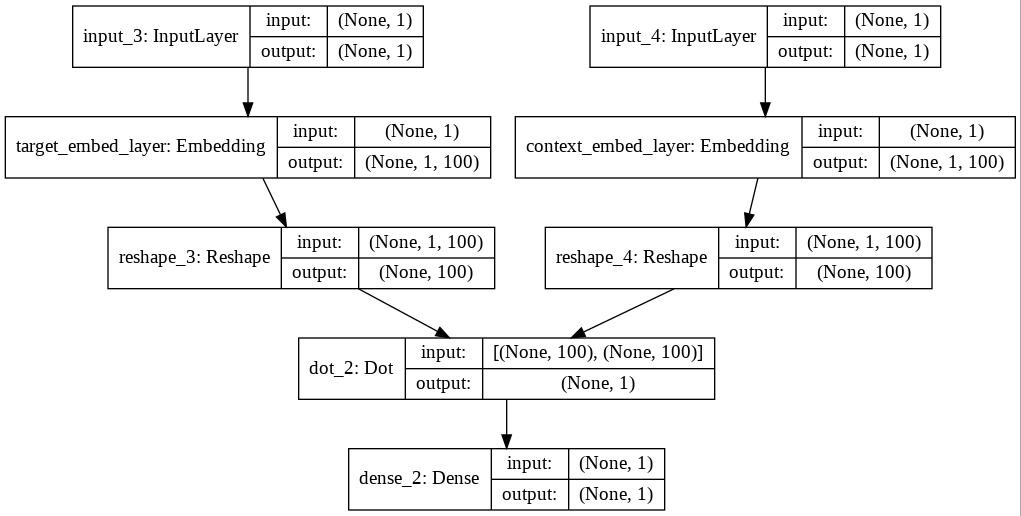

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='skipgram_keras.jpg', show_shapes=True, show_layer_names=True, rankdir='TB')


### 7. TRAINING THE MODEL

In [22]:
import numpy as np
for epoch in range(1, 6):
  epoch_loss = 0
# in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
  for i, sent_examples in enumerate(skip_grams):
      target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
      context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
      labels = np.array(sent_examples[1], dtype='int32')
      X = [target_wds, context_wds]
      Y = labels
      if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
        print('Processed %d sentences' %i)
      epoch_loss += model.train_on_batch(X, Y)
  print('Processed all %d sentences' %i)
  print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed 20000 sentences
Processed 25000 sentences
Processed 30000 sentences
Processed 35000 sentences
Processed 40000 sentences
Processed 45000 sentences
Processed 50000 sentences
Processed 55000 sentences
Processed 60000 sentences
Processed 65000 sentences
Processed 70000 sentences
Processed 75000 sentences
Processed 80000 sentences
Processed 85000 sentences
Processed 90000 sentences
Processed 95000 sentences
Processed 100000 sentences
Processed 105000 sentences
Processed 110000 sentences
Processed 115000 sentences
Processed 120000 sentences
Processed 125000 sentences
Processed 130000 sentences
Processed 135000 sentences
Processed 140000 sentences
Processed 145000 sentences
Processed 150000 sentences
Processed 155000 sentences
Processed 160000 sentences
Processed all 161778 sentences
Epoch: 1 Loss: 9100.401889336532 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sente

### 8. WORD EMBEDDINGS

In [0]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:]

9. SANITY CHECK

In [24]:
print(word_embeddings.shape)
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

(10093, 100)
                   0         1         2   ...        97        98        99
sense        0.013421  0.015533  0.007032  ... -0.006348 -0.000270 -0.010372
sensibility  0.016206 -0.033263 -0.013380  ... -0.017886  0.006081  0.006061
jane        -0.037657 -0.021620 -0.019954  ... -0.023881  0.036135  0.032490
austen      -0.002262 -0.024947 -0.003044  ...  0.011731  0.015198  0.015324
family      -0.043728 -0.002625 -0.012610  ...  0.011948  0.022412 -0.021039
dashwood    -0.030194 -0.026373 -0.036882  ...  0.022199  0.021665 -0.003428
long        -0.004798 -0.023082 -0.012606  ... -0.010263  0.016164 -0.028345
settled      0.000011  0.001130 -0.004650  ... -0.022923  0.018778  0.002552
sussex      -0.032202 -0.004081 -0.025439  ... -0.026093 -0.001165 -0.011514
estate       0.014721 -0.027056 -0.028190  ...  0.044197 -0.008823  0.060539

[10 rows x 100 columns]


### 8. SIMILARITY BETWEEN WORD PAIRS

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_embeddings)
#checking
print(similarity_matrix.shape)

(10093, 10093)


### 9. EXPLORING AND VISUALIZING WORD EMBEDDINGS T-SNE

In [0]:
search_terms = ['man', 'love', 'hatred', 'woman', 'wisdom', 'kindness', 'god', 'man', 'folly', 'fool']

### 10. GET 5 MOST SIMILAR WORDS TO SEARCH TERMS



In [0]:
similar_words = {term: [idx2word[idx]
for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1]
for term in search_terms}

### 11. PLOT WORDS SIN DICTIONARY USING t-SNE

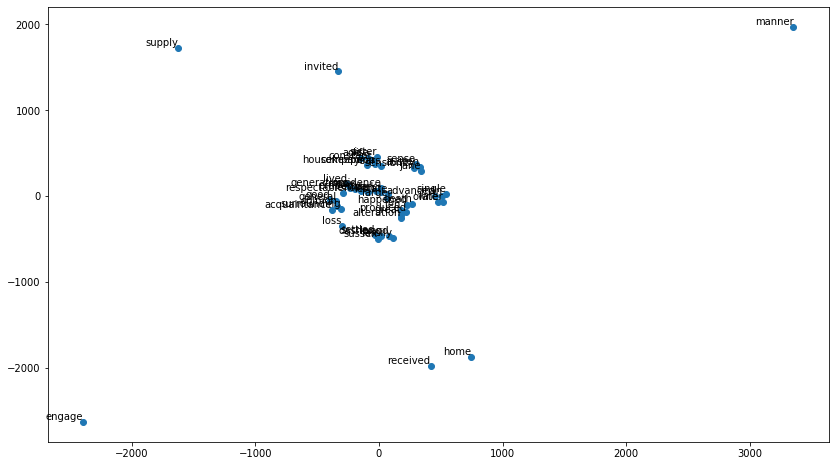

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')